# Imports

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from fitter import Fitter
import numpy as np
from pprint import pprint
from scipy import stats

# Functions

In [2]:
def trim_non_visible(s):
    """Strip if s is a string, otherwise return s."""
    if isinstance(s, str):
        return s.strip()
    return s


def read_data(file):
    """Reads the first 4 columns from the given file and drops empty rows."""
    data = pd.read_csv(
        file, delimiter=",", usecols=[0, 1, 2, 3], parse_dates=[[0, 1]]
    )
    data.columns = ["date", "m", "v"]
    data = data[data["date"] != "nan nan"]
    data = data.dropna(how="all")
    data["date"] = pd.to_datetime(data["date"])
    data = data.applymap(trim_non_visible)
    return data.sort_values(by=["date"])


def _get_time_differences(df):
    """Returns the time differences between rocks in hours."""
    return df["date"].diff().dt.total_seconds() / 3600


def add_time_differences(df):
    """Adds the time differences to the dataframe."""
    df["time_differences"] = _get_time_differences(df)
    return df


def add_energy(df):
    """Adds the energy to the dataframe."""
    df["e"] = 0.5 * df["m"] * df["v"] ** 2
    return df


def reorder_columns(df):
    """Reorders the columns of the dataframe."""
    cols = ["zone", "date", "time_differences", "m", "v", "e"]
    existing_columns = [col for col in cols if col in df.columns]
    return df[existing_columns]


def scatter_plot(
    df: pd.DataFrame,
    col: str,
    c="zone",
    colorbar=False,
    colormap="viridis",
    title=None,
):
    """Plots the given column of the given dataframe as a scatter plot."""
    if title is None:
        title = f"{col.upper()} vs. Date"
    title = title + f"\nnumber of records: {len(df)}"
    df["date"] = pd.to_datetime(df["date"])
    ax = df.plot.scatter(
        x="date", y=col, c=c, colorbar=colorbar, colormap=colormap
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.title(
        f"{col} vs. date\nnumber of records: {len(df)}"
        if title is None
        else title
    )
    plt.xticks(rotation=90)


def plot_histogram(df: pd.DataFrame, col: str, zone: int, title: str = None):
    """Plots the given column of the given dataframe as a histogram."""
    if title is None:
        title = f"{col.upper()} for Zone {zone}"
    title = title + f"\nnumber of records: {len(df)}"
    df[col].hist(bins=np.sqrt(len(df[col])).astype(int) * 6)
    plt.xlabel(col.upper())
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()


def fit(values, distributions=None):
    """Fit distributions to the values and return the best fit."""

    # Define default distributions to check
    default_distributions = [
        stats.norm,
        stats.expon,
        stats.uniform,
        stats.gamma,
        stats.lognorm,
        stats.pareto,
        stats.weibull_min,
        stats.weibull_max,
    ]

    # Use default if no distribution is specified
    if distributions is None:
        distributions = default_distributions

    # Container for results
    results = []

    # Try to fit each distribution
    for distribution in distributions:
        # Get parameters of the distribution
        params = distribution.fit(values)

        # Compute the Kolmogorov-Smirnov test to assess the goodness of fit.
        _, p = stats.kstest(values, distribution.name, args=params)

        # Append results
        results.append((distribution, p, params))

    # Sort results by p-values (higher is better)
    results.sort(key=lambda x: x[1], reverse=True)

    # Return the best fit
    return results


def plot_qq(values, fit_results, zone, col, num=5):
    """Plot Q-Q plot for the best fitting distributions."""
    for distribution, _, params in fit_results[:num]:
        plt.figure(figsize=(6, 6))
        stats.probplot(values, dist=distribution, sparams=params, plot=plt)
        plt.title(
            f"Q-Q Plot for {distribution.name} distribution vs {col.upper()} in zone {zone}"
        )
        plt.axis("equal")
        plt.show()


# EDA

In [3]:
data_1 = read_data("data/out_1.csv")
data_1["zone"] = 1
data_2 = read_data("data/out_2.csv")
data_2["zone"] = 2
# join the two dataframes and sort by date
df = pd.concat([data_1, data_2]).sort_values(by=["date"])

In [4]:
# summarize the data
print(df.describe())

                      date            m          v        zone
count                  100   100.000000  100.00000  100.000000
mean   2019-02-12 12:26:24   459.230000   18.06900    1.320000
min    2019-01-01 09:00:00     0.000000    3.60000    1.000000
25%    2019-01-21 07:45:00    76.750000    8.37500    1.000000
50%    2019-02-13 11:00:00   232.000000   10.05000    1.000000
75%    2019-03-07 11:00:00   509.750000   32.52500    2.000000
max    2019-03-28 01:00:00  3104.000000   46.50000    2.000000
std                    NaN   626.671742   14.02409    0.468826


## NAs, Zeros and Empty Strings

In [5]:
na_count = df.isna().sum()
zero_count = (df == 0).sum()
empty_string_count = (df == "").sum()

print("Number of NAs in each column:")
print(na_count)
print("\nNumber of zeros in each column:")
print(zero_count)
print("\nNumber of empty strings in each column:")
print(empty_string_count)

Number of NAs in each column:
date    0
m       0
v       0
zone    0
dtype: int64

Number of zeros in each column:
date    0
m       1
v       0
zone    0
dtype: int64

Number of empty strings in each column:
date    0
m       0
v       0
zone    0
dtype: int64


In [6]:
# summarize column 'm' for each zone
print("\n", df.groupby("zone")["m"].describe())

# replace zeros with median of the same zone
df["m"] = df.groupby("zone")["m"].transform(lambda x: x.replace(0, x.median()))

# summarize column 'm' for each zone
print("\n", df.groupby("zone")["m"].describe())


       count        mean         std   min     25%    50%    75%     max
zone                                                                   
1      68.0  628.632353  695.884703  12.0  214.75  402.5  773.0  3104.0
2      32.0   99.250000  104.072555   0.0   36.75   58.0  140.0   406.0

       count        mean         std   min     25%    50%    75%     max
zone                                                                   
1      68.0  628.632353  695.884703  12.0  214.75  402.5  773.0  3104.0
2      32.0  101.062500  102.785382   3.0   37.75   58.0  140.0   406.0


## Time Differences and Energy

In [7]:
# Add time differences and energy to the dataframes and reorder the columns.
# Also convert the zone column to a categorical variable.
# This is done so that the zone column is not used as a numerical variable.
df = reorder_columns(add_energy(add_time_differences(df)))
df["zone"] = df["zone"].astype("category")

## Write data to disk

In [8]:
# Save the zones into seperate files, so they can be compared to the original files.
df.to_csv("data/data.csv", index=False)

## Visualization
### Scatter

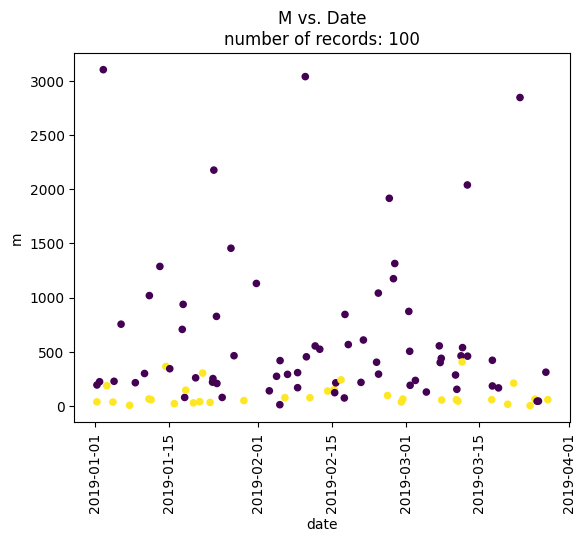

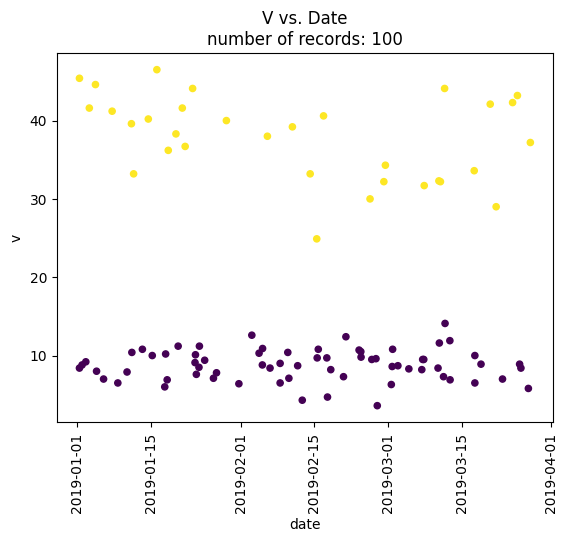

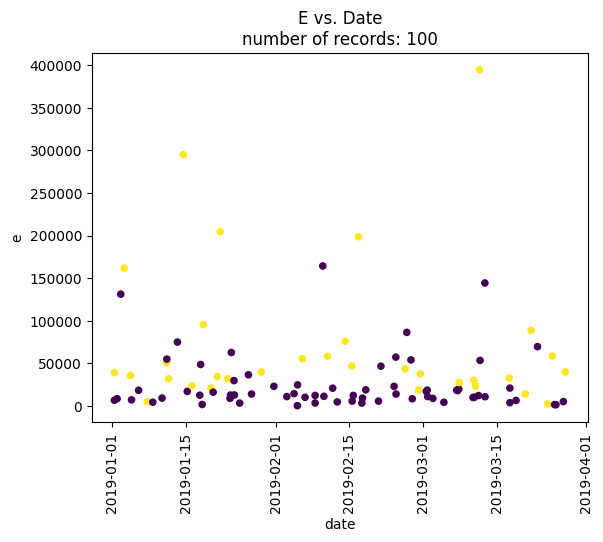

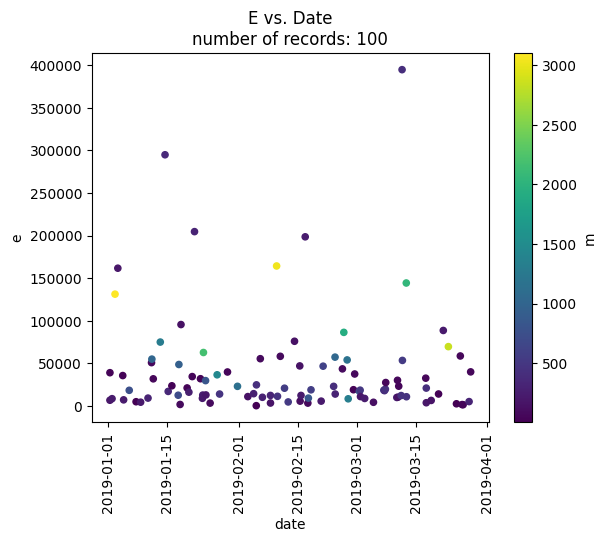

In [9]:
for col in ["m", "v", "e"]:
    scatter_plot(df, col)
scatter_plot(df, "e", c="m", colorbar=True)
plt.show()

### Histogram

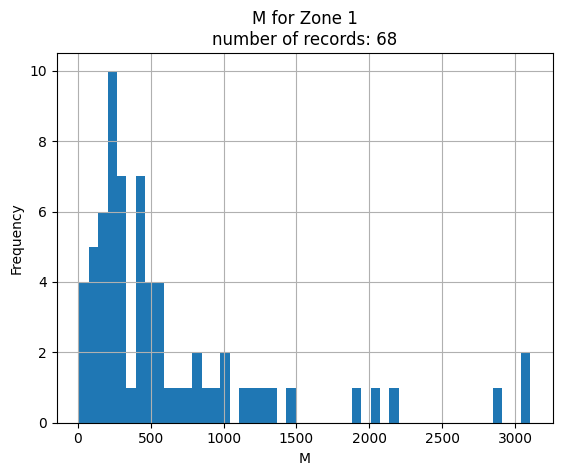

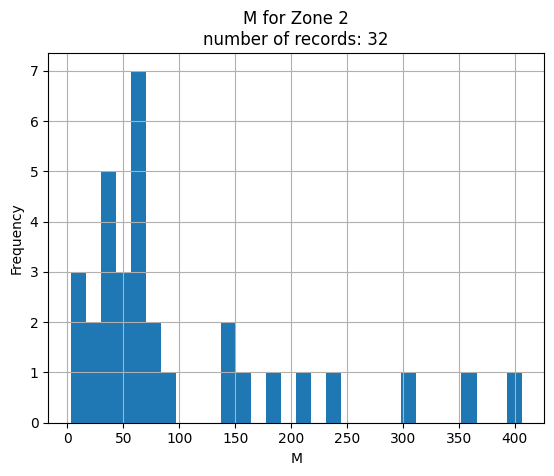

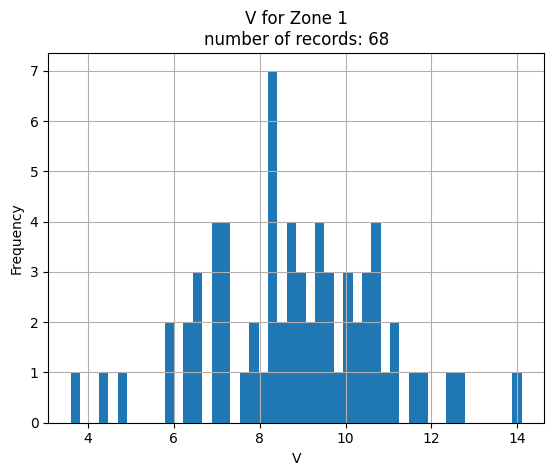

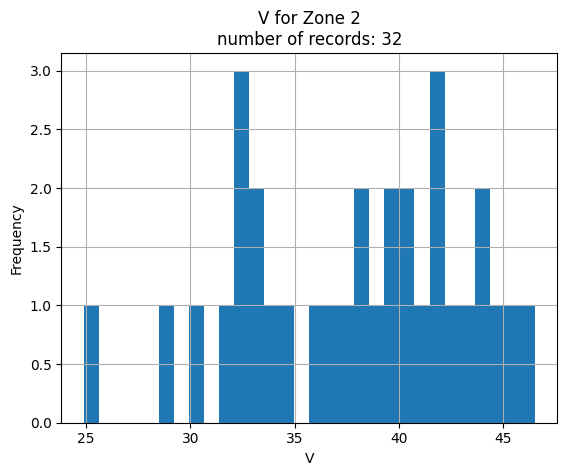

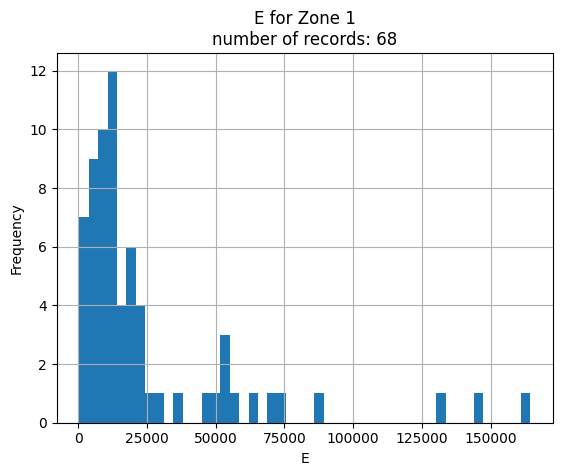

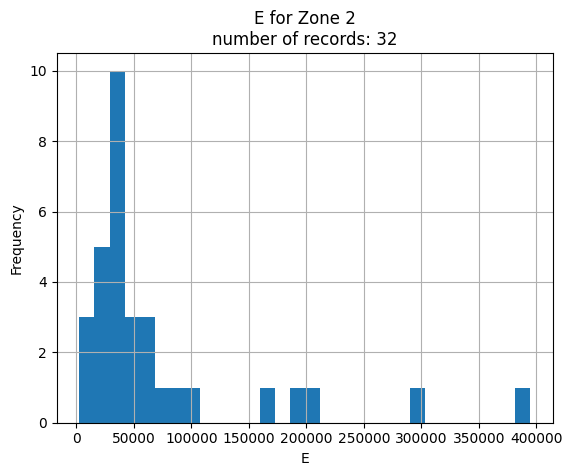

In [10]:
for col in ["m", "v", "e"]:
    for zone in [1, 2]:
        plot_histogram(df[df["zone"] == zone], col, zone)

# Fit Distributions

Zone 1, column time_differences
weibull_min
	p: 0.883384867533758
	params: (0.8753455985098517, -1.945910271100519e-28, 17.874394733453897)
gamma
	p: 0.7716626783881642
	params: (0.8197272446984147, -3.33884433330227e-23, 22.171343777368136)
lognorm
	p: 0.6262664835201585
	params: (1.1028764391574057, -0.9452333735893894, 12.018500914324097)
pareto
	p: 0.5332238903312931
	params: (56735570.51423103, -1073741824.0, 1073741823.9999999)
expon
	p: 0.5332237233196288
	params: (0.0, 18.925373134328357)


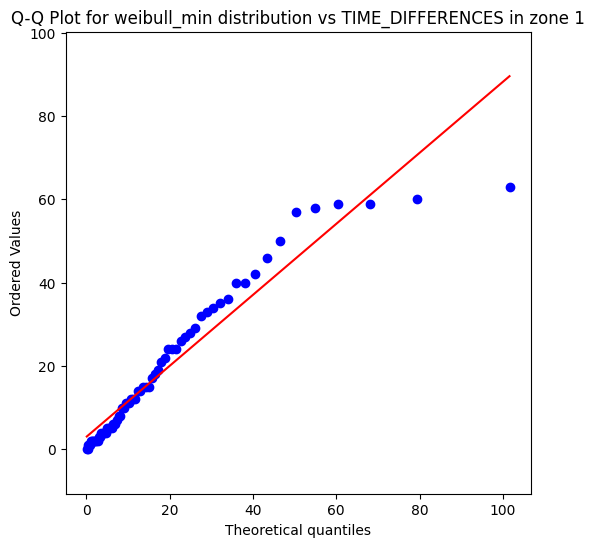

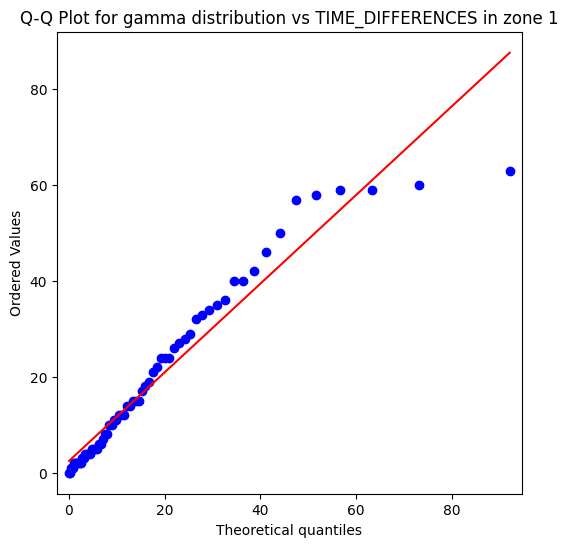

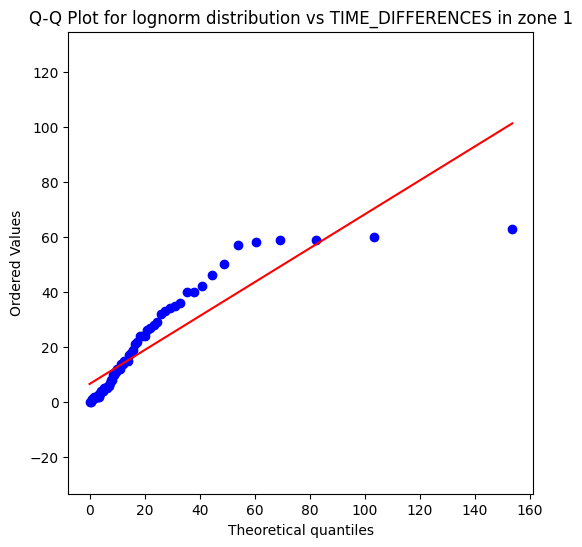

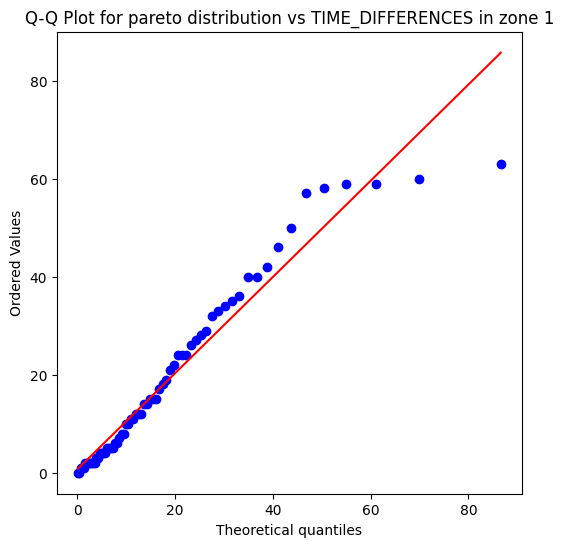

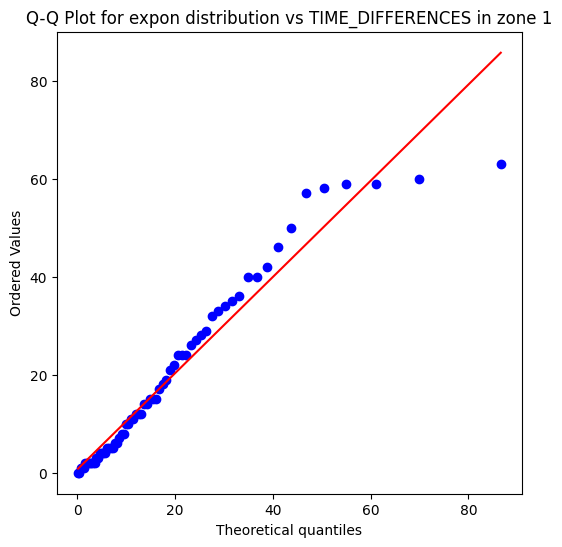

Zone 2, column time_differences
norm
	p: 0.7449438952068554
	params: (24.625, 20.338925119091225)
gamma
	p: 0.7351494130358278
	params: (1.535881507011648, -0.753356378076194, 16.523646227541796)
expon
	p: 0.31079781415140784
	params: (0.0, 24.625)
pareto
	p: 0.310797752900569
	params: (43603729.73449455, -1073741824.0, 1073741823.9999999)
weibull_min
	p: 0.07977997927982394
	params: (0.8941873029278644, 6.999999999999998, 19.708344071046476)


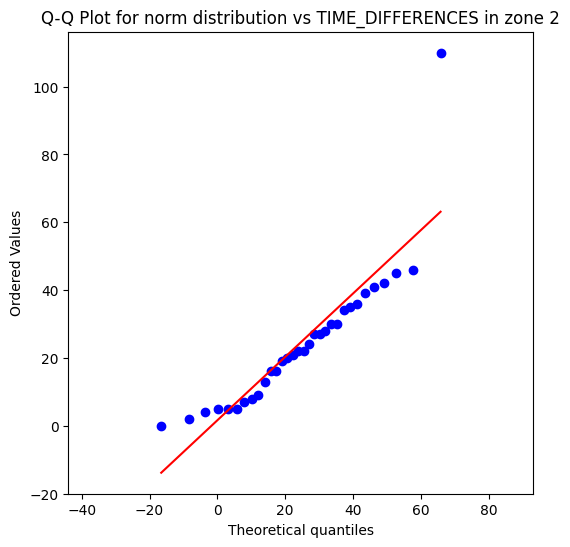

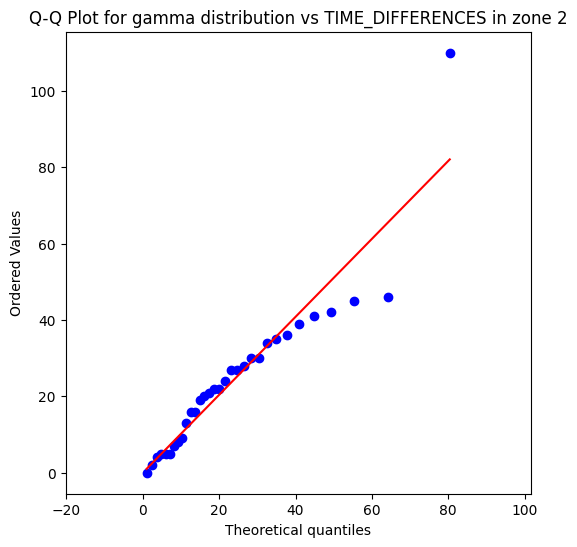

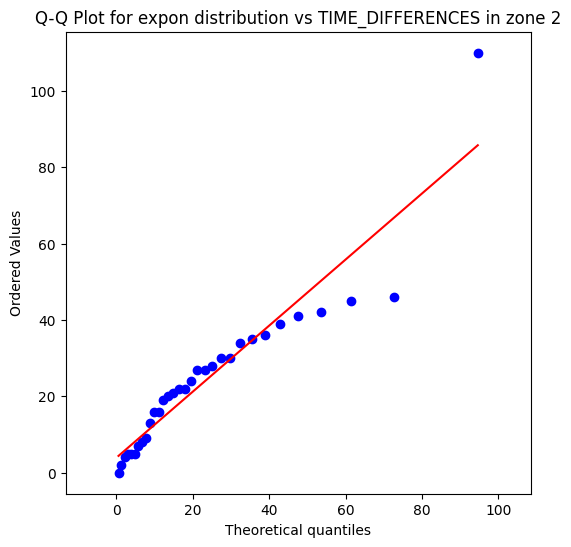

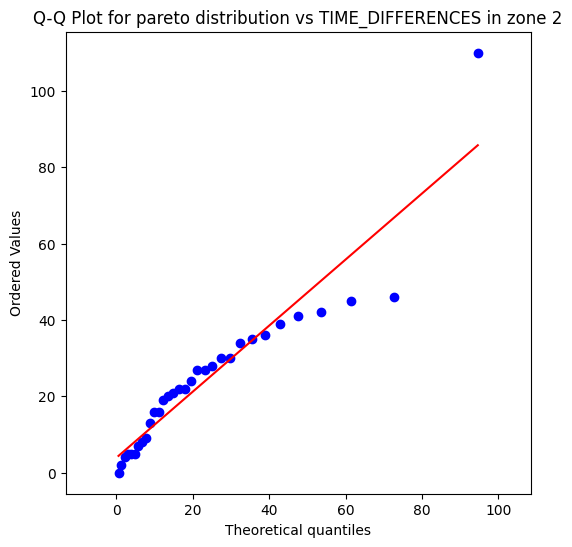

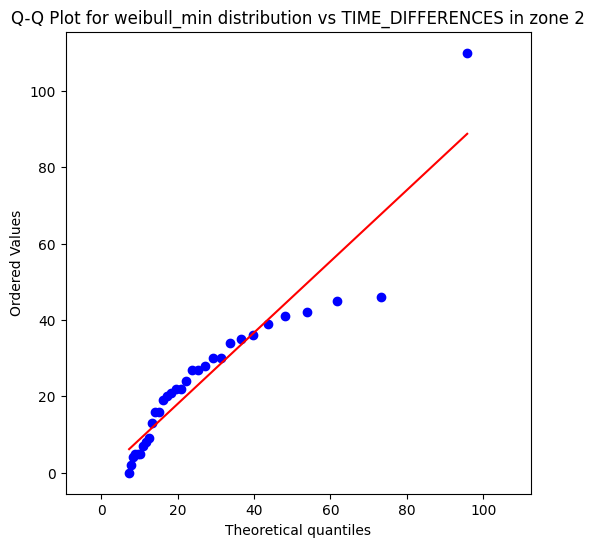

Zone 1, column m
pareto
	p: 0.49786475719087764
	params: (8.139957856906456, -4395.478359332771, 4407.47835933277)
expon
	p: 0.33130726679768424
	params: (12.0, 616.6323529411765)
weibull_min
	p: 0.29974151082494055
	params: (0.9106841716935778, 11.999999999999996, 629.0268620909127)
gamma
	p: 0.2811793039657858
	params: (0.8079614675149851, 11.999999999999998, 822.0119854583972)
norm
	p: 0.0005659509062032608
	params: (628.6323529411765, 690.7489521060746)


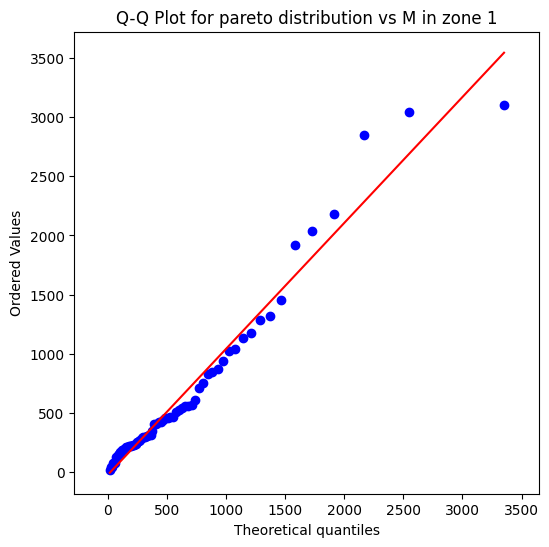

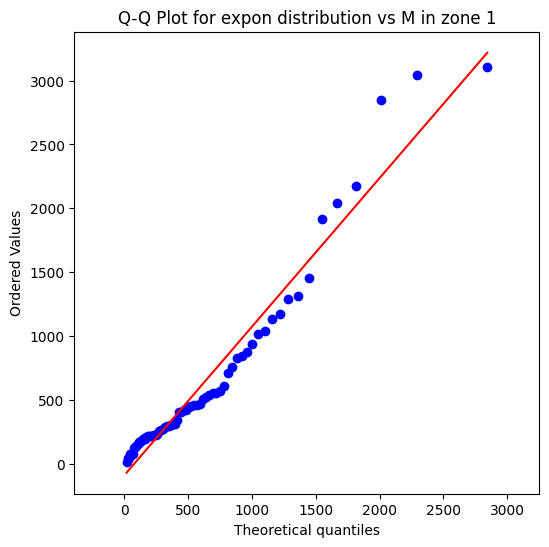

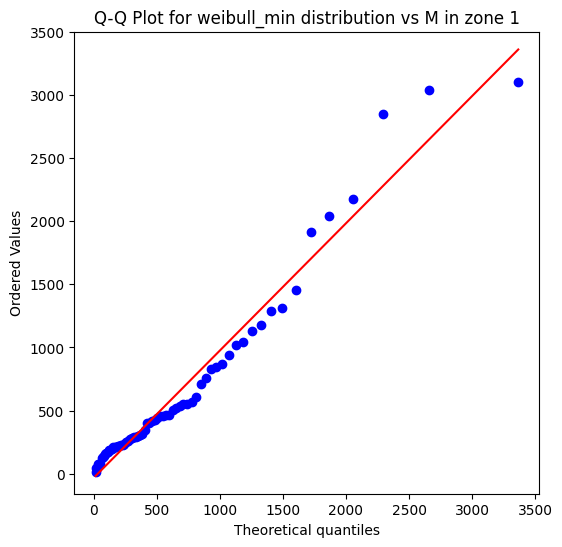

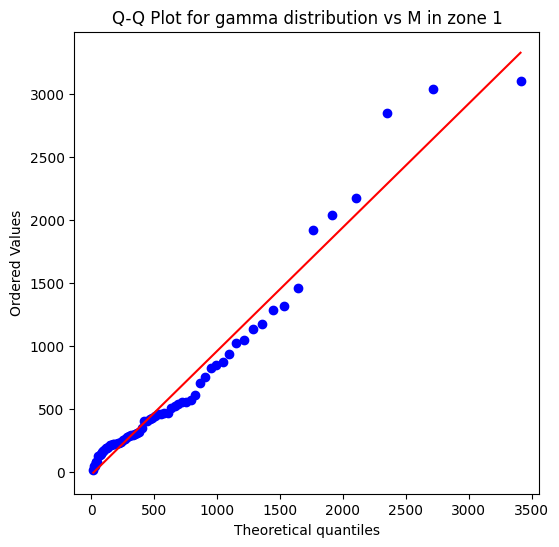

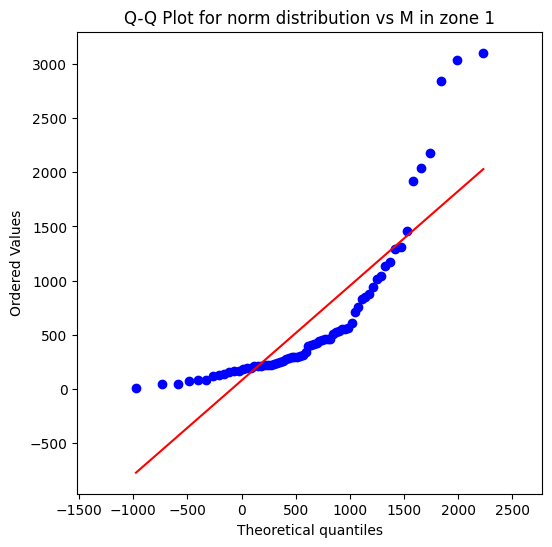

Zone 2, column m
weibull_min
	p: 0.528740841443219
	params: (0.9266230724032574, 2.999999999999999, 94.5448391798489)
pareto
	p: 0.4413179017487443
	params: (23.402211222123196, -2194.4059323972465, 2197.405932397246)
gamma
	p: 0.4133215590493271
	params: (0.9381474241389681, 2.999999999999999, 105.02431901263665)
expon
	p: 0.36526410978827384
	params: (3.0, 98.0625)
norm
	p: 0.00978854417847097
	params: (101.0625, 101.16661303883807)


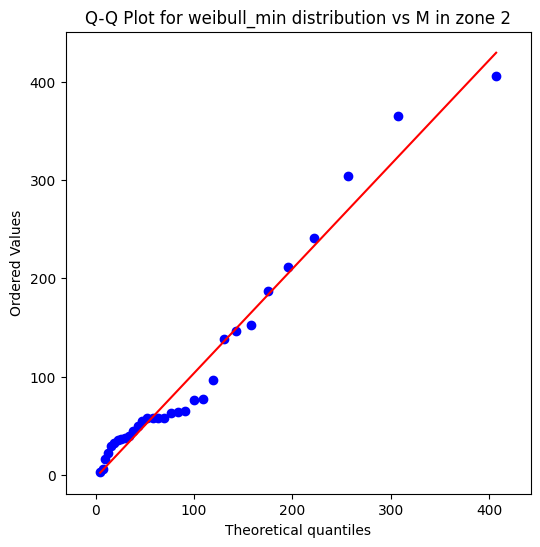

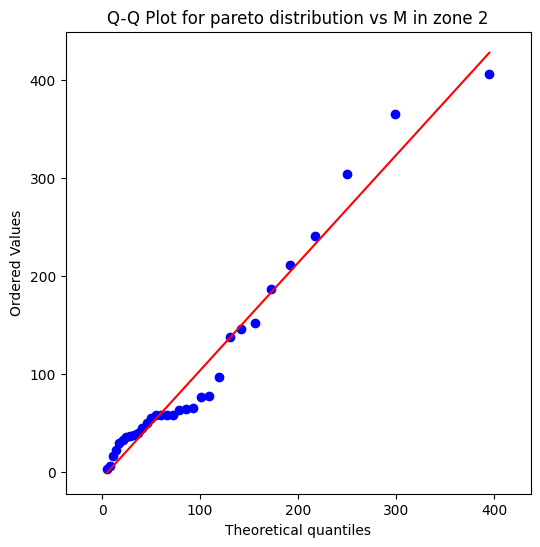

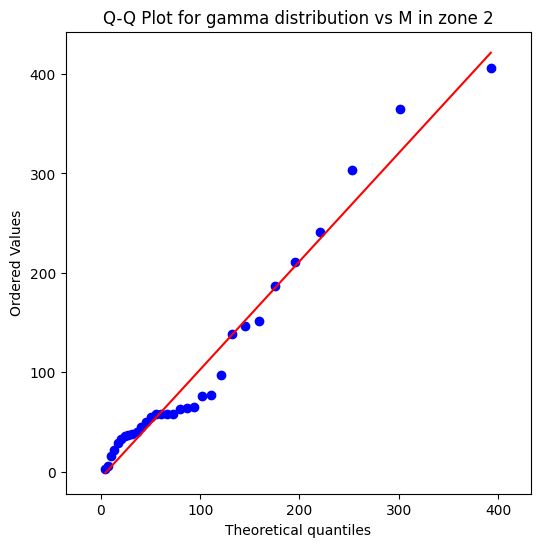

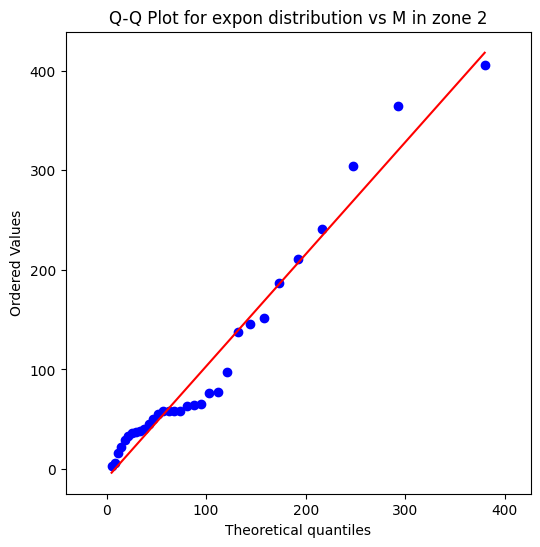

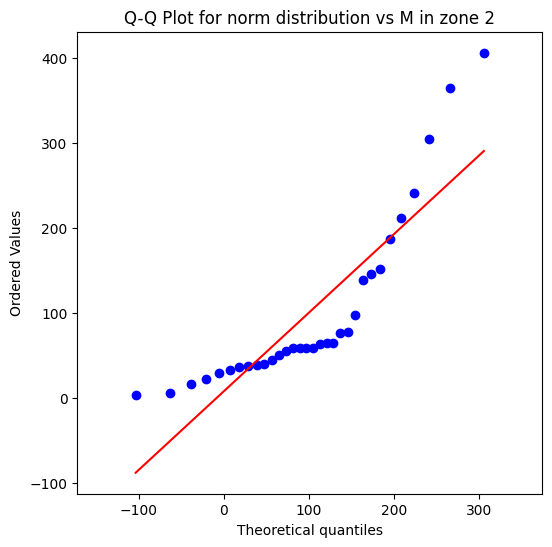

Zone 1, column v
weibull_min
	p: 0.9714980327083265
	params: (4.079735261517415, 1.5458869434704043, 7.971005972579101)
norm
	p: 0.9587295622977162
	params: (8.788235294117646, 1.9745088303442118)
lognorm
	p: 0.9519940707269448
	params: (0.0076789319250212, -247.89516201765224, 256.6759418651161)
gamma
	p: 0.9280743321416297
	params: (808.5274464550948, -47.62228137985407, 0.06977057532501355)
uniform
	p: 0.006328770688557639
	params: (3.6, 10.5)


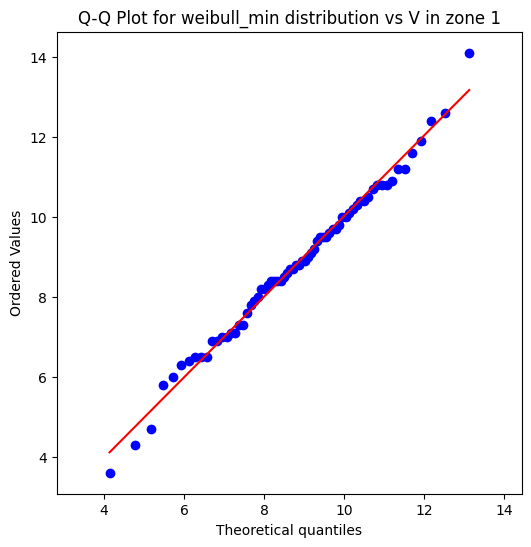

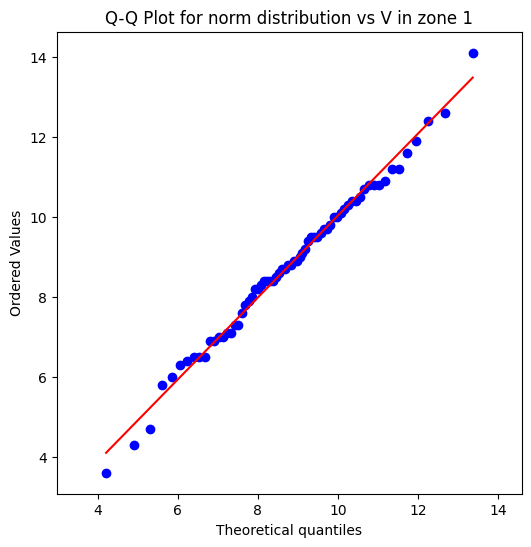

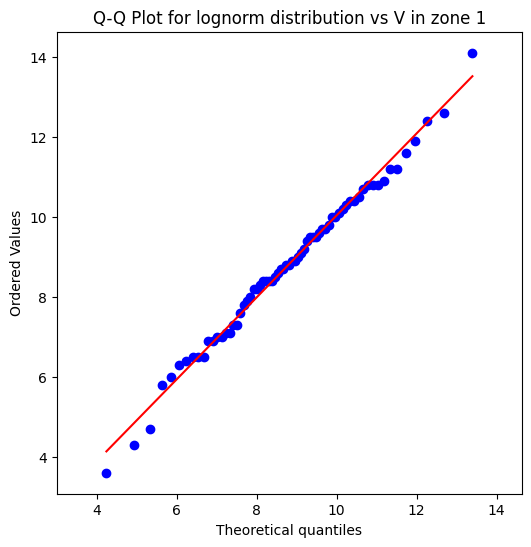

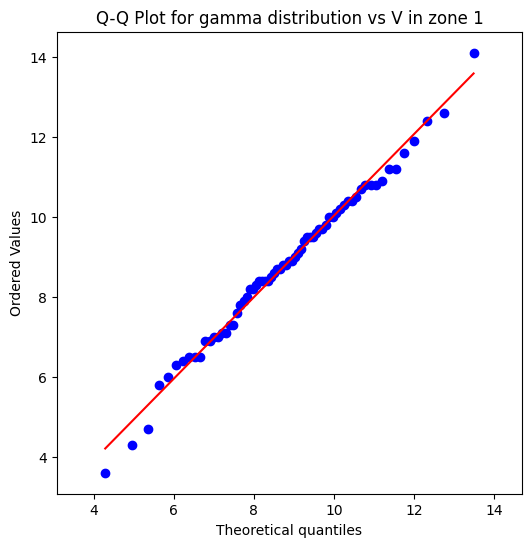

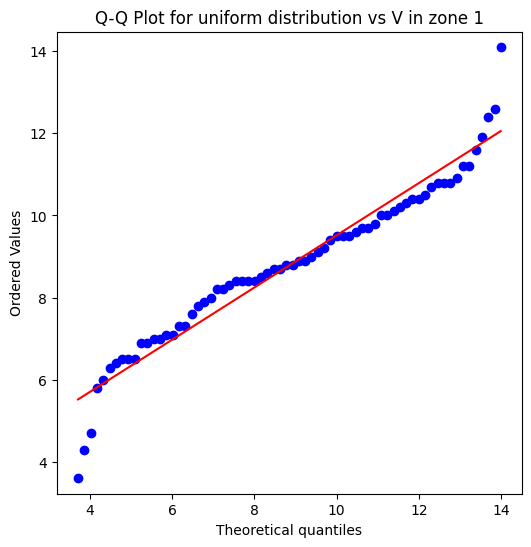

Zone 2, column v
norm
	p: 0.8391214323954682
	params: (37.790625, 5.31080027956004)
lognorm
	p: 0.8292407834815608
	params: (0.00623840856784791, -816.6351186470495, 854.4026875493)
gamma
	p: 0.7630708439594993
	params: (320.7768019244197, -58.46253026672059, 0.2999179507099794)
weibull_min
	p: 0.758154795056271
	params: (8.638735030087028, -0.22617420918062914, 40.2783815049829)
uniform
	p: 0.0745548882864373
	params: (24.9, 21.6)


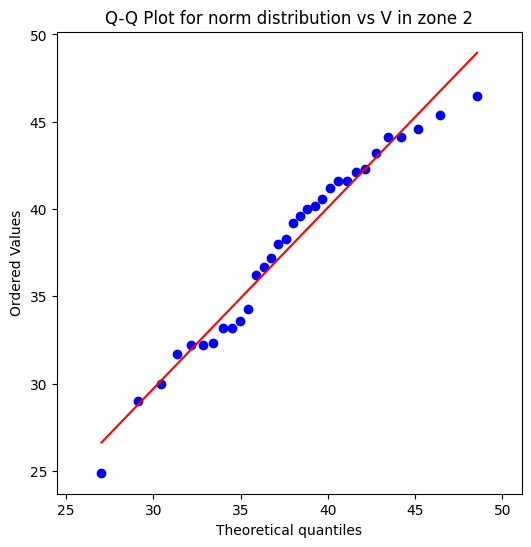

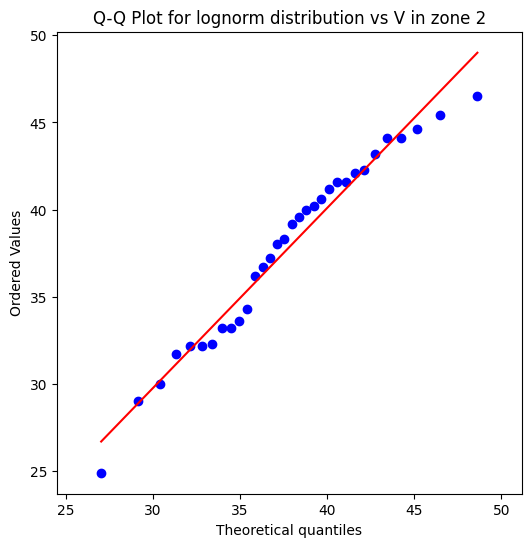

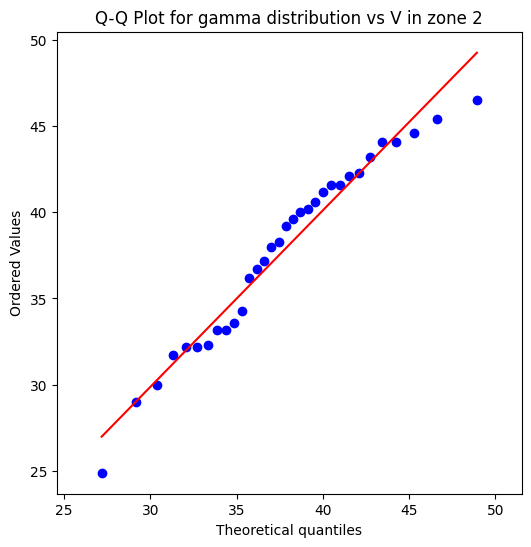

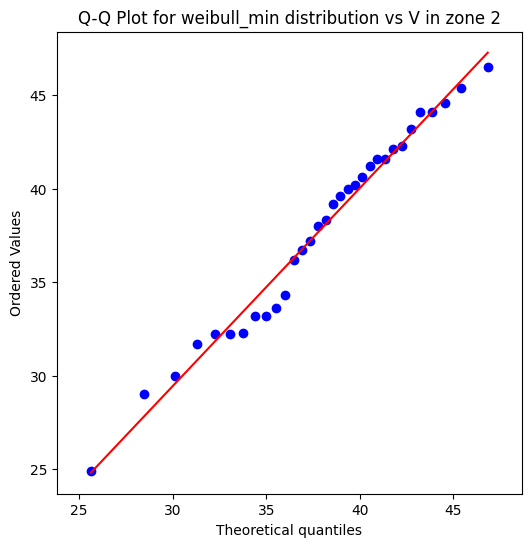

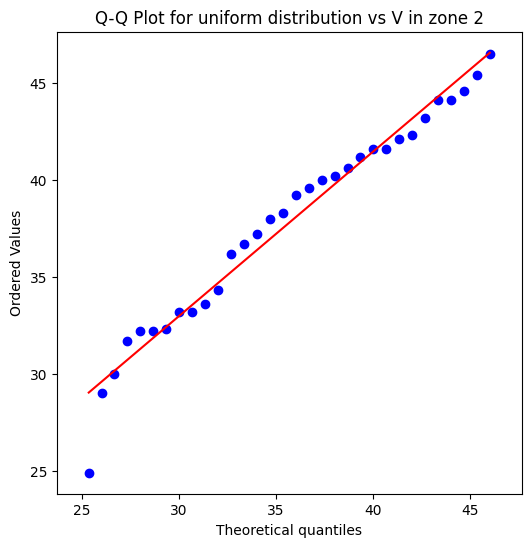

Zone 1, column e
lognorm
	p: 0.5774048130936577
	params: (1.0474041303558448, -380.63786381920573, 14630.35739041989)
pareto
	p: 0.41020363297956874
	params: (3.6215531505044236, -64845.05068678005, 65309.69068678005)
weibull_min
	p: 0.1563734299825965
	params: (0.8485779496076498, 464.64000000000004, 22808.571863677753)
gamma
	p: 0.038474702254956326
	params: (0.9558872559200986, 464.64000000000004, 26086.529225385282)
expon
	p: 0.03548559239773845
	params: (464.6400000000001, 24733.1205882353)


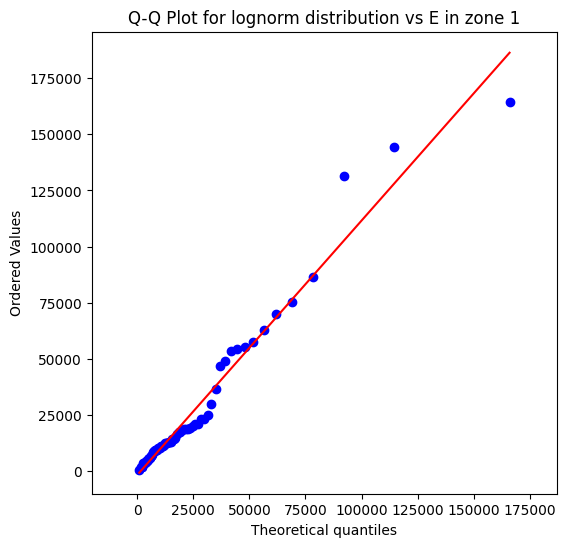

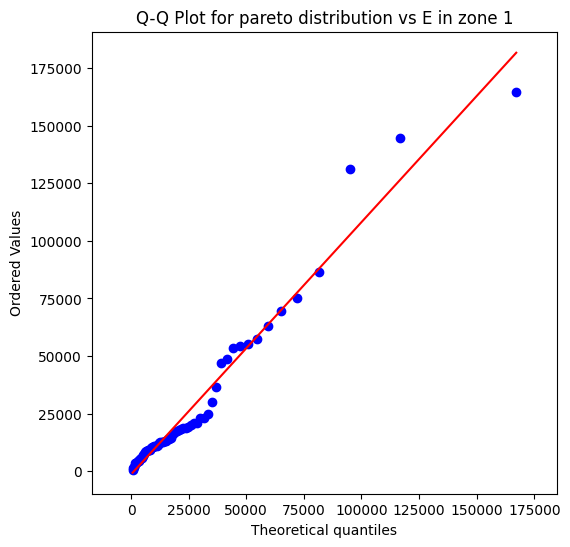

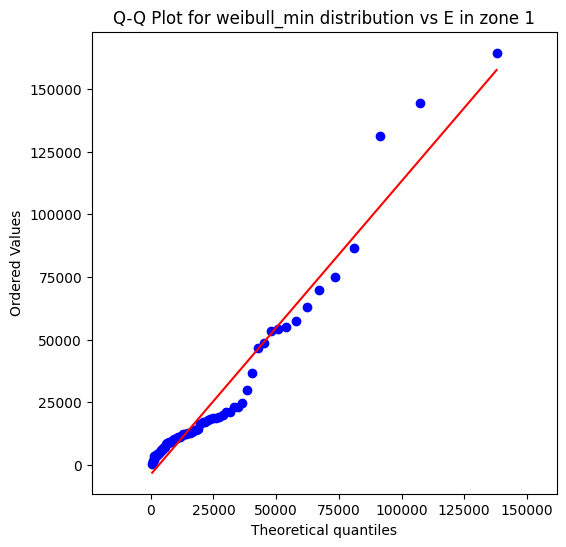

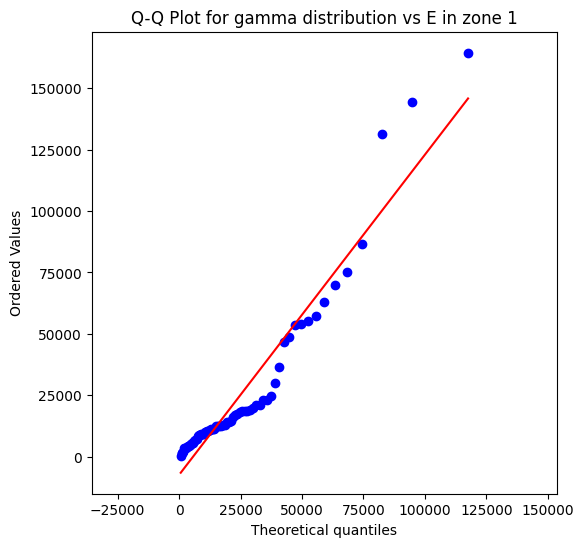

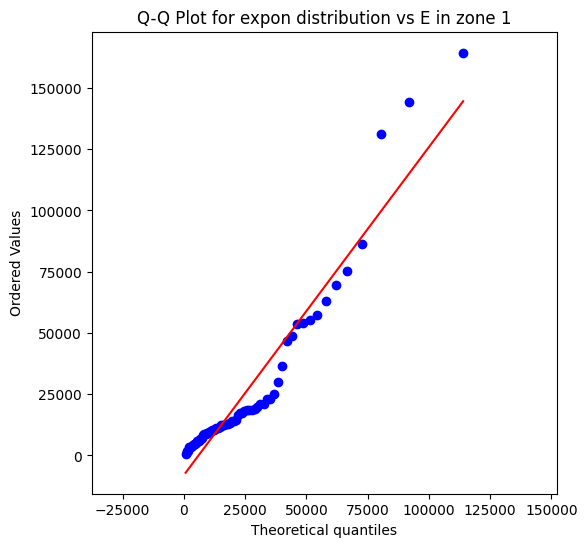

Zone 2, column e
pareto
	p: 0.3644421715505479
	params: (4.723657258500789, -258105.52782155178, 260789.46282155177)
gamma
	p: 0.31991933296993225
	params: (0.8734541624879755, 2683.934999999999, 75549.9668817301)
weibull_min
	p: 0.26145242927460477
	params: (0.8626892145330028, 2683.934999999999, 66803.16631028074)
expon
	p: 0.14191513597559668
	params: (2683.9349999999995, 69859.77156250001)
norm
	p: 0.0027117537484505627
	params: (72543.70656250001, 86075.30834696692)


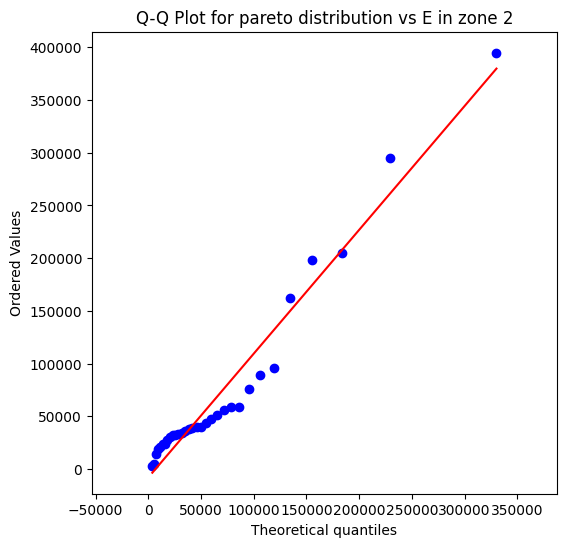

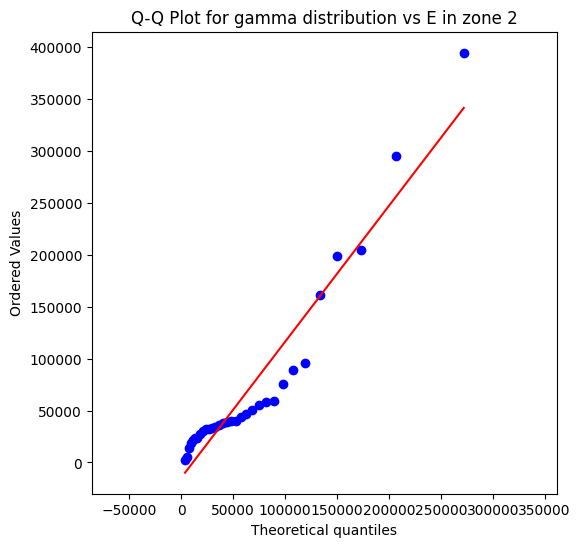

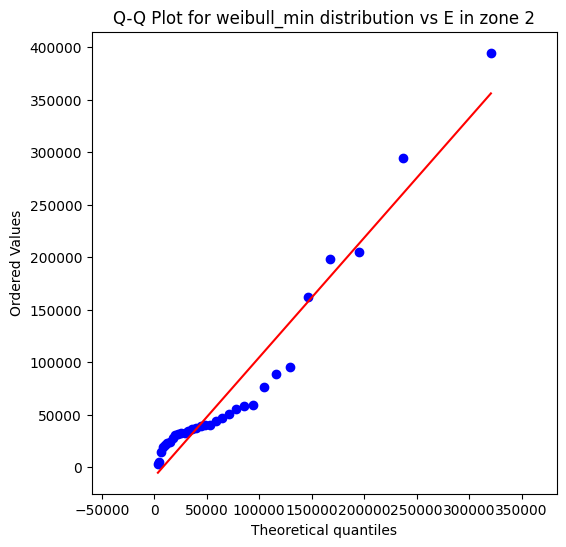

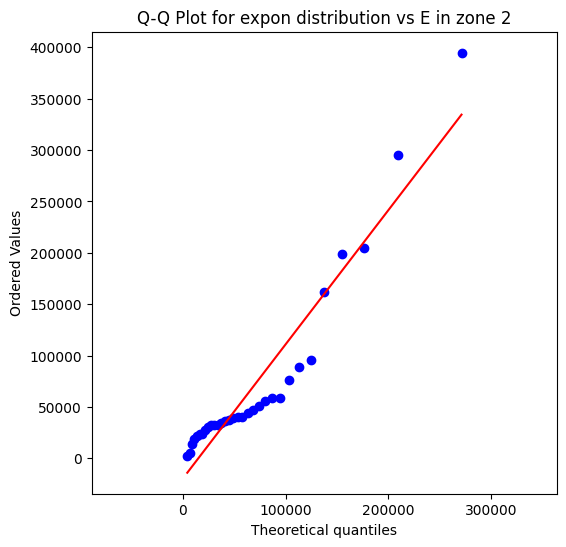

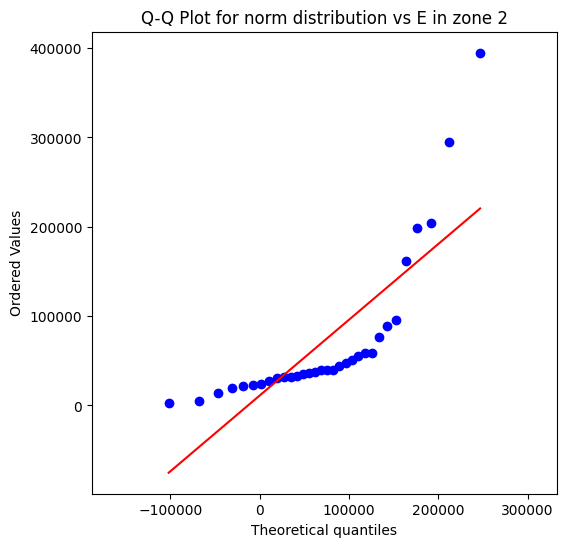

In [11]:
for col in ["time_differences", "m", "v", "e"]:
    for zone in [1, 2]:
        values = df[df["zone"] == zone][col].dropna()
        f = fit(values)
        print(f"Zone {zone}, column {col}")
        for distribution, p, params in f[:5]:
            print(f"{distribution.name}\n\tp: {p}\n\tparams: {params}")
        plot_qq(values, f, zone, col)

In [12]:
pprint([
    getattr(stats, dist)
    for dist in dir(stats)
    if isinstance(getattr(stats, dist), stats.rv_continuous) and "norm" in dist
])